# Analytic interlopers
10 October 2019

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import astropy.constants as c
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value

from numpy.random import normal

# CAMB's comoving distance function
# import sys
# sys.path.append('/n/home13/atsang/gadget4/notebooks/')
# from run_camb import get_comdist_func, get_easy_density_func
# # note: get_comdist_func is a function of z, get_density_func is a function of a
# plt.switch_backend('module://ipykernel.pylab.backend_inline')

from helpers import ADD

from scipy.special import j0
from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d, interp2d
from scipy.misc import derivative
from scipy.optimize import curve_fit

import mpmath # todo: play around with this

cosmo = FlatLambdaCDM(H0=70, Om0=0.316)

## Comoving distances
Using $z_l = 0.5$ as our default.

We can calculate $\Sigma_{cr}$ thus:
$$\Sigma_{cr} = \frac{c^2 D_s}{4\pi G D_{ds}D_d}$$

In [2]:
z_source = 1
z_lens = 0.5

a_source = 1/(1+z_source)
a_lens = 1/(1+z_lens)

chi_source = cosmo.comoving_distance(z_source) # (not /h)
chi_lens = cosmo.comoving_distance(z_lens) # (not /h)

D_s = a_source * chi_source
D_l = a_lens * chi_lens
D_ls = a_source * (chi_source - chi_lens) # this works because space is flat

sigma_crit = c.c**2 * D_s / (4 * np.pi * c.G * D_ls * D_l)
sigma_crit = sigma_crit.to(u.Msun/u.kpc**2)
sigma_crit

<Quantity 3.11639352e+09 solMass / kpc2>

Arbitrary Einstein radius

In [3]:
#### theta_E = np.sqrt(4 * c.G * mass_l / c.c**2 * D_ls / (D_l * D_s)).si
theta_E = 1.0 * np.pi/648000 # 1 arcsec
print(theta_E, 'radians')
print(theta_E * D_l.to(u.kpc))

4.84813681109536e-06 radians
6.070727349384301 kpc


In [4]:
phi_E = theta_E * cosmo.comoving_distance(z_lens) / (cosmo.comoving_distance(z_source)-cosmo.comoving_distance(z_lens))
def cone_R_units(z):
    # returns a comoving distance
    forwards_cone_R = theta_E * cosmo.comoving_distance(z)
    backwards_cone_R = phi_E * (cosmo.comoving_distance(z_source) - cosmo.comoving_distance(z))
    return np.minimum(forwards_cone_R, backwards_cone_R).to(u.kpc)

def cone_R_kpc_slow(z):
    return cone_R_units(z).to(u.kpc).value

In [5]:
z_vals = np.linspace(0,1,1000)
cone_R_kpc = interp1d(z_vals, cone_R_kpc_slow(z_vals))

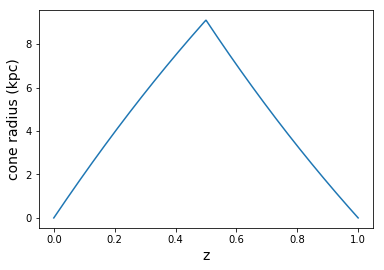

In [6]:
plt.plot(z_vals, cone_R_kpc(z_vals))
plt.xlabel('z', size=14)
plt.ylabel('cone radius (kpc)', size=14)
plt.show()

### Derivative $d\chi / dz$
We'll interpolate to save time while integrating

In [7]:
z_vals = np.linspace(1e-5,1-1e-5,200)
dchi_dz_func = interp1d(z_vals, 1000*derivative(cosmo.comoving_distance, z_vals, dx=.00001)) # in terms of kpc (cosmo.comoving_distance was in Mpc)

In [8]:
quad(dchi_dz_func, 0, 1)

(3273040.465985017, 0.0010850666121287622)

Text(0.5, 0, 'z')

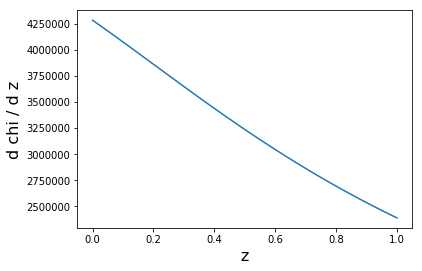

In [9]:
plt.plot(z_vals, dchi_dz_func(z_vals))
plt.ylabel('d chi / d z', size=16)
plt.xlabel('z', size=16)

## Effective masses

[//]: # (**Note** : This numpy file we're about to load assumes that $z_l = 0.5$ and $z_s = 1.0$. Also, what a weird comment syntax!)

We're not using Despali's mass function anymore.

In [10]:
# We'll write these functions in these fancy ways so numpy won't make a fuss about vectorizing
def f_func(z):
    zi = np.min([z, z_lens*np.ones_like(z)], axis=0)
    zj = np.max([z, z_lens*np.ones_like(z)], axis=0)
    zs = z_source * np.ones_like(z)
    beta = (cosmo.angular_diameter_distance_z1z2(zi, zj)
            * cosmo.angular_diameter_distance(zs)
            / (cosmo.angular_diameter_distance(zj)
              * cosmo.angular_diameter_distance_z1z2(zi, zs)))
    return 1 - beta

def g_func(z):
    beta_li = ( cosmo.angular_diameter_distance_z1z2(z_lens, z)
                * cosmo.angular_diameter_distance(z_source)
                /
                (cosmo.angular_diameter_distance(z)
                 * cosmo.angular_diameter_distance_z1z2(z_lens, z_source)) )
        
    bg_bool = z > z_lens
    return 1 - bg_bool*beta_li
    
#     if z <= z_lens:
#         return 1
#     else:
#         return 1 - beta_li
#g_func = np.vectorize(g_func_orig)

/n/home13/atsang/.local/lib/python3.6/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/n/home13/atsang/.local/lib/python3.6/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 0, 'z')

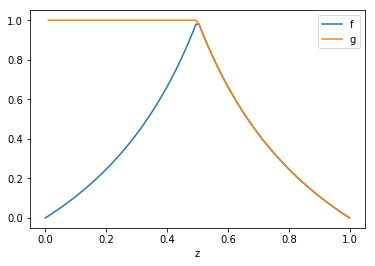

In [11]:
z_vals = np.linspace(0,1,100)
plt.plot(z_vals, f_func(z_vals), label='f')
plt.plot(z_vals, g_func(z_vals), label='g')
plt.legend()
plt.xlabel('z')

**Testing here**

There seems to (still) be disagreement about what the form of this meff function should be. Before, I had
$$fg^2 \frac{D_l D_{is}}{D_{ls} D_i}$$
and the plateau was too low (around 4.3e-6).

In [12]:
def meff_func(z):
    zs = z_source * np.ones_like(z)
    return (f_func(z) / (g_func(z)**2) * cosmo.angular_diameter_distance(z_lens)/cosmo.angular_diameter_distance_z1z2(z_lens, z_source)
                                       * (cosmo.angular_diameter_distance_z1z2(z, zs) / cosmo.angular_diameter_distance(z)))

In [13]:
# The bad, crazy version
# def meff_func(zi,zl=z_lens,zs=z_source):
#     ### NEW meff ratio ###
#     Dl = ADD(0.,zl)
#     Di = ADD(0.,zi)
#     Ds = ADD(0.,zs)
#     Dls = ADD(zl,zs)
#     Dis = ADD(zi,zs)
#     if zi < zl:
#         Dil = ADD(zi,zl)
#         return (((Dl/Di))*(Dis/Dls))*(1.+((Dil*Ds)/(Dis*Dl)))
#     if zi >= zl:
#         Dli = ADD(zl,zi)
#         return ((Dl/Di))*(Dis/Dls)*(1./(1.-((Dli*Ds)/(Dls*Di))))

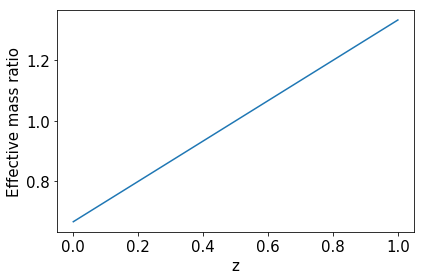

In [14]:
# def meff_func(z_inter):
#     # z_inter is the redshift of the interloper
#     a_inter = 1/(1+z_inter)
#     chi_inter = cosmo.comoving_distance(z_inter)
#     D_i = a_inter * chi_inter
#     D_is = a_source * (chi_source - chi_inter)
    
#     if z_inter == z_lens:
#         return 1
#     elif z_inter < z_lens: # foreground interloper
#         return D_i * D_is / D_l / D_ls
#     else: # background interloper
#         D_li = a_inter * (chi_inter - chi_lens)
#         return (1-D_li*D_s/D_i/D_ls)*D_i*D_is/D_l/D_ls

z_vals = np.linspace(1e-5,1-1e-5,100)
meff_vals = np.array([meff_func(z) for z in z_vals])

plt.plot(z_vals, meff_vals)
#plt.text(.85,1.05,'$z_l = 0.5$',size=15)
plt.xlabel('z',fontsize=15)
plt.ylabel('Effective mass ratio',fontsize=15)
plt.gca().tick_params(labelsize=15)
#plt.gca().set_yscale('log')

plt.tight_layout()
#plt.savefig('imgs/effective_mass_dec10.pdf')
plt.show()

In [15]:
# define meff_ratio_func as a linear interpolation (so this will be faster when it goes into the integral)
meff_ratio_func = interp1d(z_vals, meff_vals)

In [16]:
meff_func(.00001)

<Quantity 0.66667333>

In [17]:
meff_ratio_func(.99)

array(1.32666667)

## t-NFW Profile: $\hat \kappa$

In [18]:
def mass_by_massNFW(tau):
    # helper function to calculate kappa_hat
    return tau**2 / (1+tau**2)**2 * ((tau**2 - 1)*np.log(tau) + tau * np.pi - (tau**2+1))

def kappa_hat_kpc(rs, rt):
    def kappa_hat_r(r):
        '''
        Returns value of kappa_hat at r, in kpc^2 (todo: double-check units)
        
        Recall kappa_hat = Sigma_crit * kappa / m .
        We're not using astropy units (this function must be integrated)
        
        Also, note when we cast a complex down to a real,
        we've already mathematically guaranteed that those are real numbers,
        so it's safe to ignore the warning.
        '''

        x = r/rs
        tau = rt/rs
        
        # to calculate bigF:
        if isinstance(x, np.ndarray):
            x = np.array(x, dtype='complex')
            arccos = np.arccos
            sqrt = np.sqrt
            log = np.log
        elif isinstance(x, mpmath.mpf):
            x = mpmath.mpc(x)
            arccos = mpmath.acos
            sqrt = mpmath.sqrt
            log = mpmath.log
        else:
            x = complex(x)
            arccos = np.arccos
            sqrt = np.sqrt
            log = np.log
            
        bigF = arccos(1/x) / (x**2-1)**.5
        bigF = abs(bigF).real
        
        if isinstance(x, np.ndarray):
            x = np.array(x, dtype='float')
            bigF = np.array(bigF, dtype='float')
        elif isinstance(x, mpmath.mpc):
            x = x.real
            bigF = bigF.real
        else:
            x = abs(x)
            bigF = abs(bigF)
            
        bigL = log(x / (sqrt(tau**2 + x**2) + tau))

        prefactor = 1 / (rs**2) * tau**2 / (2*np.pi*(tau**2+1)**2)
        term1 = (tau**2+1)/(x**2-1) * (1-bigF)
        term2 = 2*bigF
        term3 = - np.pi / sqrt(tau**2 + x**2)
        term4 = (tau**2 - 1)/(tau * sqrt(tau**2 + x**2)) * bigL

        return 1/mass_by_massNFW(tau) * prefactor * (term1 + term2 + term3 + term4)
    return kappa_hat_r

/n/home13/atsang/.conda/envs/jup3/lib/python3.7/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part


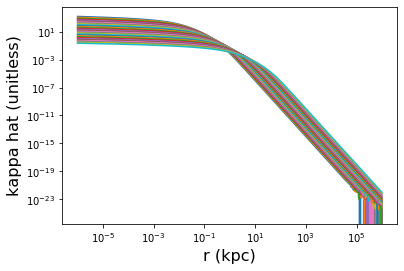

In [19]:
rs_rt_list = np.load('files/kappa_tilde_results/kappa_tildes_rs_rt_deltawide.npy')

for rs, rt in rs_rt_list: #zip(rs_vals_m1to9delta, rt_vals_m1to9delta):
    r_vals = np.logspace(-6,6,500)
    plt.loglog(r_vals, kappa_hat_kpc(rs, rt)(r_vals))
    
plt.xlabel('r (kpc)', size=16)
plt.ylabel('kappa hat (unitless)', size=16)
plt.show()

*Above* : Each color represents a different (rs, rt) pair, and the curves are the convergence profile of a single subhalo/interloper. Remember that the hat in $\hat \kappa$ means that we scale out the mass and $\Sigma_{cr}$ dependence.

## `quadosc` test
In this part, we test out MPMath's `quadosc` function. It's an integration method different from the regular `quad` which can greatly speed up integrals that involve Bessel functions. However, it is not always as accurate or as fast. 

Here, we want to calculate the integral from Equation 26 in arxiv:1707.04590 (Ana's paper):
$$\tilde \kappa(k) = 2\pi \int dr \cdot r J_0(kr) \hat \kappa(r)$$

In [ ]:
def kappa_tilde_integrand_kpc(k, rs, rt):
    # assume all inputs are values in units of kpc already
    # output will be unitless anyway
    
    kappa_hat_r = kappa_hat_kpc(rs, rt)
    def integrand(r):
        return (2 * np.pi * r * mpmath.j0(k * r) * kappa_hat_r(r))
    return integrand

In [ ]:
%%time
# fancy mpmath quadosc
krs_list = np.logspace(-5,2,20) # kpc/kpc

kappa_tildes_osc_big = np.zeros(len(krs_list))
for i,krs in enumerate(krs_list):
    print('%.2f, '%krs,end="")
    #j0zero = lambda n: mpmath.findroot(kappa_tilde_integrand_kpc(k, .1, 2), np.pi*(n-0.25))
    kappa_tildes_osc_big[i] = mpmath.quadosc(kappa_tilde_integrand_kpc(krs, 1, 20),
                                     [0, mpmath.inf], 
                                     period=2*np.pi/krs)
                                     #zeros=j0zero)
                                     #period=2*np.pi/k, error=True)

In [ ]:
%%time
# regular scipy `quad`
krs_list = np.logspace(-5,2,20) # kpc/kpc

kappa_tildes_big = np.zeros([len(krs_list),2])
for i,krs in enumerate(krs_list):
    print('%.2f, '%krs, end="")
    kappa_tildes_big[i] = quad(kappa_tilde_integrand_kpc(krs, 1, 20),
                                     1e-10, np.inf, limit=1000)

In [ ]:
plt.loglog(krs_list, kappa_tildes_osc_big, label='osc')
plt.loglog(krs_list, kappa_tildes_big[:,0], label='quad')
plt.loglog(krs_list, kappa_tildes_big[:,1], label='quad err')
plt.loglog(krs_list, abs(kappa_tildes_osc_big - kappa_tildes_big[:,0]), label='quad-osc diff')
plt.legend()
plt.xlabel('$kr_s$ (unitless)')
plt.show()

**Conclusion:** In terms of accuracy, regular `quad` is better for k < 1 kpc. For higher k, it's unclear, but probably `osc` is better. Also `quad` is faster for low k (roughly k < 1 kpc) and `osc` is much faster for high k (roughly k > 1 kpc).

**Good version demo**

In [ ]:
%%time
krs_list = np.logspace(-5,2,20) # kpc/kpc

kappa_tildes_good = np.zeros(len(krs_list))
for i,krs in enumerate(krs_list):
    print('%.2f, '%krs,end="")
    if krs > 1:
        kappa_tildes_good[i] = mpmath.quadosc(kappa_tilde_integrand_kpc(krs, 1, 20),
                                         [0, mpmath.inf], 
                                         period=2*np.pi/krs)
    else:
        kappa_tildes_good[i] = quad(kappa_tilde_integrand_kpc(krs, 1, 20), 1e-10, np.inf, limit=1000)[0]

## 3D Fourier transform: $\tilde \kappa$

Don't need to run this every time -- can just load results!

**Assume that $r_t / r_s =$ const.**

Since it turns out that (as long as $\tau = r_s / r_t$ is fixed) $\tilde\kappa$ is a function simply of $k r_s$, we can simplify this to a 1d interpolation:

In [29]:
def kappa_tilde_integrand_kpc(k, rs, rt):
    # assume all inputs are values in units of kpc already
    # output will be unitless anyway
    
    kappa_hat_r = kappa_hat_kpc(rs, rt)
    def integrand(r):
        return (2 * np.pi * r * mpmath.j0(k * r) * kappa_hat_r(r))
    return integrand

In [30]:
%%time
krs_list = np.logspace(-5,3,200) # kpc/kpc

kappa_tildes = np.zeros(len(krs_list))
for i,krs in enumerate(krs_list):
    print('%.2f, '%krs,end="")
    if krs > 1:
        kappa_tildes[i] = mpmath.quadosc(kappa_tilde_integrand_kpc(krs, 1, 20),
                                         [0, mpmath.inf], 
                                         period=2*np.pi/krs)
    else:
        res = quad(kappa_tilde_integrand_kpc(krs, 1, 20), 1e-10, np.inf, limit=1000)
        kappa_tildes[i] = res[0]
        if abs(res[1]/res[0]) > .01:
            print('rel error', res[1]/res[0], 'for krs', krs)

0.00, 

NameError: name 'kappa_hat_kpc' is not defined

In [ ]:
"""
np.save('files/kappa_tilde_results/kappa_tildes.npy', kappa_tildes)
np.save('files/kappa_tilde_results/kappa_tildes_krs.npy', krs_list)
"""

### Load previously-calculated $\tilde\kappa$ results

In [18]:
# load results
kappa_tildes = np.load('files/kappa_tilde_results/kappa_tildes.npy')
krs_list = np.load('files/kappa_tilde_results/kappa_tildes_krs.npy')

kappa_tilde_func = interp1d(krs_list, kappa_tildes)

(array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
        1.e+00, 1.e+01, 1.e+02]), <a list of 11 Text yticklabel objects>)

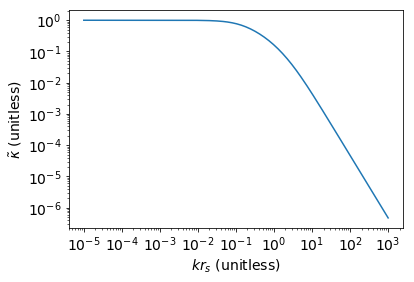

In [19]:
plt.loglog(krs_list, kappa_tildes)
plt.xlabel('$kr_s$ (unitless)', size=14)
plt.ylabel('$\\tilde\\kappa$ (unitless)', size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [20]:
# Now to make a "safe" version
def linfit(x, a, b):
    return 10**(a*np.log10(x) + b)

# curve fit for high krs:
popt, pcov = curve_fit(linfit, krs_list[krs_list > 10], kappa_tildes[krs_list > 10])

(array([1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01,
        1.e+03]), <a list of 9 Text yticklabel objects>)

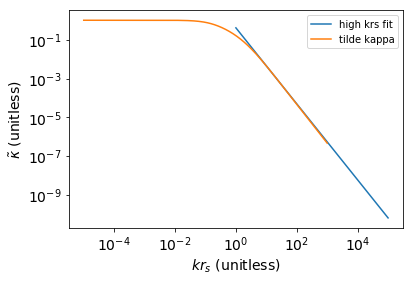

In [21]:
krs_all = np.logspace(0,5)
plt.loglog(krs_all, linfit(krs_all, *popt), label='high krs fit')
plt.loglog(krs_list, kappa_tildes, label='tilde kappa')
plt.legend()
plt.xlabel('$kr_s$ (unitless)', size=14)
plt.ylabel('$\\tilde\\kappa$ (unitless)', size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [22]:
def kappa_tilde_safe(krs):
    krs = np.array(krs, dtype=np.float64)
    return np.piecewise(krs,
                       [krs <= np.min(krs_list), krs >= np.max(krs_list)], # last condition is "else" case
                       [lambda krs: 1, lambda krs: linfit(krs, *popt), lambda krs: kappa_tilde_func(krs)])

(array([1.e-15, 1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01,
        1.e+01, 1.e+03]), <a list of 10 Text yticklabel objects>)

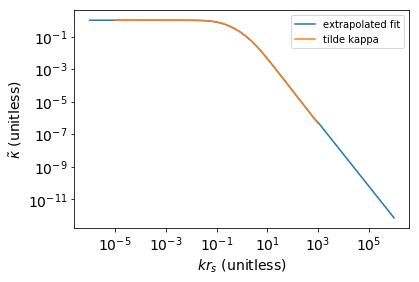

In [23]:
krs_all = np.logspace(-6,6)
plt.loglog(krs_all, kappa_tilde_safe(krs_all), label='extrapolated fit')
plt.loglog(krs_list, kappa_tildes, label='tilde kappa')
plt.legend()
plt.xlabel('$kr_s$ (unitless)', size=14)
plt.ylabel('$\\tilde\\kappa$ (unitless)', size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [24]:
kappa_tilde_safe(1e-17)

array(1.)

In [25]:
kappa_tilde_safe(1)

array(0.161231)

In [26]:
kappa_tilde_safe([1e-17, 1., 1e5])

array([1.00000000e+00, 1.61230998e-01, 6.65115136e-11])

### Approximate mass vals

We start with a simple function for $r_s$ as a function of mass:

In [27]:
def rs_to_mass(rs):
    # rs is number of kpc
    # mass is number of Msun
    return 1e6 * (rs/0.1)**3

def mass_to_rs(m):
    return 0.1 * (m/1e6)**(1/3)

But how do we extend this to the case of interlopers?

$$\tilde\kappa_\mathrm{eff}(k r_s) = \tilde\kappa\left(\frac{D_\ell}{D_i}\frac{1}{g}k r_s\right)$$
where $g = 1$ for foreground and $g = 1- \beta_{\ell i}$ for background.

## Cagan's Sheth-Tormen output

`massfunc` has units of 1/(Mpc/h)^3 / M_sun (comoving distance). `massesn` has units of $M_\odot$.

In [28]:
h = .675
massesn = np.load('files/st_results/0_massesn_ST.npy') # Msun
massfunc_matrix = np.load('files/st_results/0_massfunc_ST.npy') /1000**3 # convert 1/Mpc^3 to 1/kpc^3
zs = np.load('files/st_results/0_redshifts_ST.npy')

massfunc = interp2d(zs, massesn, massfunc_matrix, bounds_error=True)

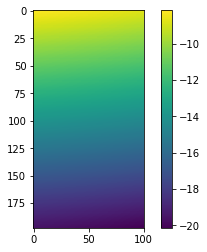

In [29]:
plt.imshow(np.log10(massfunc_matrix)); plt.colorbar()

*Above:* x-axis represents redshift; y-axis represents mass.

In [30]:
def massfunc_safe(z, mass):
    '''
    Pretend that the number density of galaxies heavier
    than our highest mass is exactly 0 (rather than throwing an error)
    '''
    if mass > massesn[-1]:
        return 0
    else:
        return massfunc(z, mass)

In [31]:
## test ##
massfunc_safe(.5, 1e7) # 1/kpc^3

array([1.11035709e-14])

## Synthesis

Before we do the total integral, let's calculate a simplified version, just to get the order of magnitude
$$P(k) \approx \frac{1}{\Sigma_{cr}^2} \chi_s \int_{10^5}^{10^8} m^2 n(z_l, m) \left| \tilde\kappa(k r_s(m)) \right|^2 dm$$

In [32]:
sigma_crit = sigma_crit.to(u.Msun / u.kpc**2)

integral = quad(lambda m: m**2 * massfunc_safe(z_lens, m) * kappa_tilde_func(1e-3 * mass_to_rs(m)), 1e5, 1e8) # for k = 1e-3
print('integral error', integral[1]/integral[0])
1/sigma_crit**2 * chi_source.to(u.kpc) * integral[0] * u.Msun**2 * u.kpc**-3

integral error 0.001088496928084608


/n/home13/atsang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  This is separate from the ipykernel package so we can avoid doing imports until


<Quantity 4.18485939e-05 kpc2>

In [33]:
klist = np.logspace(-3,2,10)
def calc_power_approx(k):
    return 1/sigma_crit**2 * chi_source.to(u.kpc) * quad(lambda m: m**2 * massfunc_safe(z_lens, m) * kappa_tilde_func(k*mass_to_rs(m)), 1e5, 1e8)[0] * u.Msun**2 * u.kpc**-3

plist = [calc_power_approx(k).to(u.kpc**2).value for k in klist]

/n/home13/atsang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  This is separate from the ipykernel package so we can avoid doing imports until


Second approximation (still no effective mass ratio):
$$P(k) \approx \frac{1}{\Sigma_{cr}^2} \int_0^1 dz \frac{d\chi}{dz} \frac{R^2(z)}{R^2(z_l)} \int_{10^5}^{10^8} m^2 n(z_l, m) \left| \tilde\kappa(k r_s(m)) \right|^2 dm$$

In [34]:
def calc_power_approx2(k):
    return ( 1/sigma_crit**2 * quad(lambda z:
                                  dchi_dz_func(z) # already in kpc
                                  * cone_R_kpc(z)**2 / cone_R_kpc(z_lens)**2, 0,1)[0] * u.kpc
       * quad(lambda m: m**2 * massfunc_safe(z_lens, m) * kappa_tilde_func(k * mass_to_rs(m)), 1e5, 1e8)[0]
                                  * u.Msun**2 * u.kpc**-3 )

plist2 = [calc_power_approx2(k).to(u.kpc**2).value for k in klist]
print(plist2[0])

/n/home13/atsang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


1.3977816810430232e-05


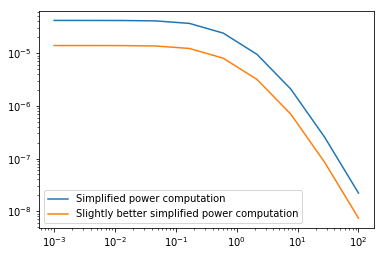

In [35]:
#plt.title('z_l = 2')
plt.loglog(klist, plist, label='Simplified power computation')
plt.loglog(klist, plist2, label='Slightly better simplified power computation')
plt.legend()

### Interloper effect ratios

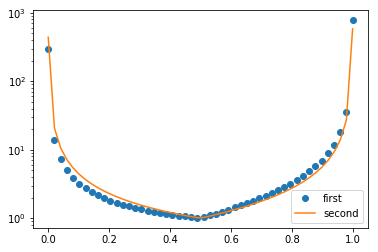

In [36]:
## Test
z_list = np.linspace(.001,.999)
def rad_ratio(z):
    return cosmo.angular_diameter_distance(z_lens) / cosmo.angular_diameter_distance(z) / g_func(z)
def second_func(z):
    cone_R_lens = cone_R_kpc_slow(z_lens)
    rad_ratio_func = lambda cone_R: cone_R_lens / cone_R
    return rad_ratio_func(cone_R_kpc(z))
plt.plot(z_list, rad_ratio(z_list), 'o', label='first')
plt.plot(z_list, second_func(z_list), label='second')
plt.gca().set_yscale('log')
plt.legend()

Total integral:
$$\newcommand{\abs}[1]{{\left| #1 \right|}}$$
$$P_I(k) = \frac{\pi}{A \Sigma_\mathrm{cr}^2} \int_0^1 dz \int_{10^5}^{10^8} dm_\mathrm{eff}\, \left[\frac{dm}{dm_\mathrm{eff}}\right]_z m^2_\mathrm{eff}\, \frac{d\chi}{dz} R^2(z) n(z,m) \abs{\tilde \kappa_i(k F(z) r_s(m))}^2$$
where $F(z) = \frac{D_l}{D_i g(z)} \approx \frac{R_{cone}(z_l)}{R_{cone}(z)} \geq 1$ represents the magnification from projecting to an effective convergence along a cone.
Here, $\frac{dm}{dm_\mathrm{eff}} = \frac{1}{\texttt{mass_ratio_func}(z)}$ and $m = \frac{m_\mathrm{eff}}{\texttt{mass_ratio_func}(z)}$.

With simple bounds:
$$P_I(k) = \frac{\pi}{A \Sigma_\mathrm{cr}^2} \int_0^1 dz \int_{10^5}^{10^8} dm \cdot m_\mathrm{eff}^2 \frac{d\chi}{dz} R^2(z) n(z, m) \left| \tilde\kappa_i(k F(z) r_s(m)) \right|^2$$

In [46]:
cone_R_lens = cone_R_kpc_slow(z_lens)

def full_integrand_kpc(k, numerics_factor=1, meff_bool=True, ratio_bool=True):
    '''
    The `numerics_factor` is multiplied to the final answer,
    which can make scipy's integration more accurate,
    but you have to remember to divide it out at the end!
    '''
    
    area = np.pi * cone_R_lens**2
    normalization = np.pi / (area * sigma_crit.to(u.M_sun/u.kpc**2).value**2)
    
    
    if ratio_bool:
        my_ratio_func = rad_ratio
    else:
        my_ratio_func = lambda z : 1
    
    
    if meff_bool:
        my_meff_func = meff_ratio_func
    else:
        my_meff_func = lambda z : 1
    
    
    def integrand(z,meff):
        meff_factor = my_meff_func(z)
        dm_dmeff = 1/meff_factor
        dchi_dz = dchi_dz_func(z) # already kpc
        cone_R = cone_R_kpc(z)
        n = massfunc_safe(z,meff/meff_factor) # if physical mass is too high, will return 0
        kap = kappa_tilde_safe(k*my_ratio_func(z)*mass_to_rs(meff/meff_factor))
        
        ans = dm_dmeff * meff**2 * dchi_dz * cone_R**2 * n * kap**2
        
        return numerics_factor * normalization * ans
    
    def integrand_simple_bounds(z, m):
        meff = m * my_meff_func(z)
        dchi_dz = dchi_dz_func(z) # already kpc
        cone_R = cone_R_kpc(z)
        n = massfunc_safe(z,m) # if physical mass is too high, will return 0
        kap = kappa_tilde_safe(k*my_ratio_func(z)*mass_to_rs(m))
        ans = meff**2 * dchi_dz * cone_R**2 * n * kap**2
        
        return numerics_factor * normalization * ans

    return integrand_simple_bounds
    #return integrand

def calc_power_spec(k_vals, verbose=False, numerics_factor=1, meff_bool=True, ratio_bool=True,
                   mass_range=(1e5,1e8)):
    full_integrands = np.zeros(len(k_vals)) #secretly units of M_sun^2
    full_errors = np.zeros(len(k_vals))
    
    if verbose: print('k, Power, Power rel err')
        
    for i, k in enumerate(k_vals):

        # dblquad ordering is a little weird: func(z,m), bounds of m, bounds of z (as functions of m)
        q = dblquad(full_integrand_kpc(k, numerics_factor=numerics_factor,
                                       meff_bool=meff_bool, ratio_bool=ratio_bool),
                    mass_range[0], mass_range[1],
                    lambda m: 0.01, lambda m: 0.99,
                    epsrel=0.5) # can also set epsabs
        q = (q[0]/numerics_factor, q[1]/numerics_factor)

        full_integrands[i] = q[0]
        full_errors[i] = q[1]
        if verbose: print(k, q[0], q[1]/q[0])
        
    return np.vstack([k_vals, full_integrands]).T, full_errors

### Power spectrum itself

In [39]:
dblquad(full_integrand_kpc(0), 1e5, 1e8, lambda m: 0.01, lambda m: 0.99)

(1.3759836434557587e-05, 4.722860272910267e-09)

In [47]:
%%time

k_vals = np.logspace(-3, 2, 30) # 1/kpc

ps_interlopers, ps_interlopers_err = calc_power_spec(k_vals,
                                                    numerics_factor=1e10)

CPU times: user 2min 27s, sys: 31.8 ms, total: 2min 27s
Wall time: 2min 29s


In [48]:
ps_interlopers # real bounds

array([[1.00000000e-03, 1.35390167e-05],
       [1.48735211e-03, 1.35372235e-05],
       [2.21221629e-03, 1.35336294e-05],
       [3.29034456e-03, 1.35265003e-05],
       [4.89390092e-03, 1.35125324e-05],
       [7.27895384e-03, 1.34855728e-05],
       [1.08263673e-02, 1.34344823e-05],
       [1.61026203e-02, 1.33398115e-05],
       [2.39502662e-02, 1.31692242e-05],
       [3.56224789e-02, 1.28725076e-05],
       [5.29831691e-02, 1.23789870e-05],
       [7.88046282e-02, 1.16036547e-05],
       [1.17210230e-01, 1.04710346e-05],
       [1.74332882e-01, 8.96092715e-06],
       [2.59294380e-01, 7.16028607e-06],
       [3.85662042e-01, 5.27307538e-06],
       [5.73615251e-01, 3.55235337e-06],
       [8.53167852e-01, 2.18393008e-06],
       [1.26896100e+00, 1.22429138e-06],
       [1.88739182e+00, 6.24455383e-07],
       [2.80721620e+00, 2.88912792e-07],
       [4.17531894e+00, 1.21037244e-07],
       [6.21016942e+00, 4.59836110e-08],
       [9.23670857e+00, 1.59154296e-08],
       [1.373823

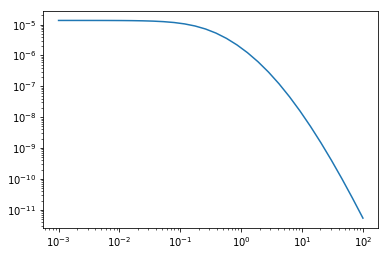

In [49]:
plt.loglog(ps_interlopers[:,0], ps_interlopers[:,1])

In [42]:
ps_interlopers_realbounds = np.array([[1.00000000e-02, 1.36692206e-05],
       [1.48735211e-02, 1.35865796e-05],
       [2.21221629e-02, 1.34358146e-05],
       [3.29034456e-02, 1.31697759e-05],
       [4.89390092e-02, 1.27199649e-05],
       [7.27895384e-02, 1.19998026e-05],
       [1.08263673e-01, 1.09260025e-05],
       [1.61026203e-01, 9.46071463e-06],
       [2.39502662e-01, 7.66846523e-06],
       [3.56224789e-01, 5.73897043e-06],
       [5.29831691e-01, 3.93185317e-06],
       [7.88046282e-01, 2.45850579e-06],
       [1.17210230e+00, 1.40181801e-06],
       [1.74332882e+00, 7.27633004e-07],
       [2.59294380e+00, 3.42744841e-07],
       [3.85662042e+00, 1.46199981e-07],
       [5.73615251e+00, 5.65300597e-08],
       [8.53167852e+00, 1.98920130e-08],
       [1.26896100e+01, 6.41020241e-09],
       [1.88739182e+01, 1.90402348e-09],
       [2.80721620e+01, 5.23806084e-10],
       [4.17531894e+01, 1.34080203e-10],
       [6.21016942e+01, 3.21420948e-11],
       [9.23670857e+01, 7.28648815e-12],
       [1.37382380e+02, 1.58377038e-12],
       [2.04335972e+02, 3.34800417e-13],
       [3.03919538e+02, 6.96012987e-14],
       [4.52035366e+02, 1.43354766e-14],
       [6.72335754e+02, 2.94068364e-15],
       [1.00000000e+03, 6.02152776e-16]])

In [50]:
ps_interlopers_simplebounds = np.array([[1.00000000e-03, 1.35390167e-05],
       [1.48735211e-03, 1.35372235e-05],
       [2.21221629e-03, 1.35336294e-05],
       [3.29034456e-03, 1.35265003e-05],
       [4.89390092e-03, 1.35125324e-05],
       [7.27895384e-03, 1.34855728e-05],
       [1.08263673e-02, 1.34344823e-05],
       [1.61026203e-02, 1.33398115e-05],
       [2.39502662e-02, 1.31692242e-05],
       [3.56224789e-02, 1.28725076e-05],
       [5.29831691e-02, 1.23789870e-05],
       [7.88046282e-02, 1.16036547e-05],
       [1.17210230e-01, 1.04710346e-05],
       [1.74332882e-01, 8.96092715e-06],
       [2.59294380e-01, 7.16028607e-06],
       [3.85662042e-01, 5.27307538e-06],
       [5.73615251e-01, 3.55235337e-06],
       [8.53167852e-01, 2.18393008e-06],
       [1.26896100e+00, 1.22429138e-06],
       [1.88739182e+00, 6.24455383e-07],
       [2.80721620e+00, 2.88912792e-07],
       [4.17531894e+00, 1.21037244e-07],
       [6.21016942e+00, 4.59836110e-08],
       [9.23670857e+00, 1.59154296e-08],
       [1.37382380e+01, 5.05161955e-09],
       [2.04335972e+01, 1.47906879e-09],
       [3.03919538e+01, 4.01532116e-10],
       [4.52035366e+01, 1.01500188e-10],
       [6.72335754e+01, 2.40589176e-11],
       [1.00000000e+02, 5.40717233e-12]])

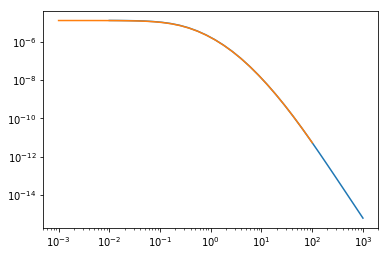

In [51]:
plt.loglog(ps_interlopers_realbounds[:,0], ps_interlopers_realbounds[:,1])
plt.loglog(ps_interlopers_simplebounds[:,0], ps_interlopers_simplebounds[:,1])

In [52]:
"""
np.savetxt('files/analytic_curves/arthurcagan2.txt', ps_interlopers_simplebounds)
"""

In [64]:
4.13e-6 / h**3

1.3428847228572879e-05

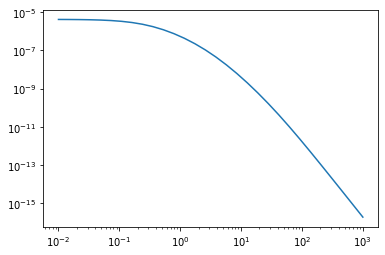

In [58]:
plt.loglog(ps_interlopers[:,0], ps_interlopers[:,1])

In [38]:
ps_interlopers = np.array([[1.00000000e-02, 2.96144235e-06],
       [1.48735211e-02, 2.94469871e-06],
       [2.21221629e-02, 2.91395330e-06],
       [3.29034456e-02, 2.85930822e-06],
       [4.89390092e-02, 2.76615969e-06],
       [7.27895384e-02, 2.61569135e-06],
       [1.08263673e-01, 2.38901591e-06],
       [1.61026203e-01, 2.07642308e-06],
       [2.39502662e-01, 1.69006224e-06],
       [3.56224789e-01, 1.27016491e-06],
       [5.29831691e-01, 8.73670052e-07],
       [7.88046282e-01, 5.48296053e-07],
       [1.17210230e+00, 3.13702851e-07],
       [1.74332882e+00, 1.63351095e-07],
       [2.59294380e+00, 7.71767288e-08],
       [3.85662042e+00, 3.30090163e-08],
       [5.73615251e+00, 1.27936223e-08],
       [8.53167852e+00, 4.51098569e-09],
       [1.26896100e+01, 1.45616440e-09],
       [1.88739182e+01, 4.33203892e-10],
       [2.80721620e+01, 1.19334985e-10],
       [4.17531894e+01, 3.05823425e-11],
       [6.21016942e+01, 7.33894951e-12],
       [9.23670857e+01, 1.66497317e-12],
       [1.37382380e+02, 3.62086669e-13],
       [2.04335972e+02, 7.65657039e-14],
       [3.03919538e+02, 1.59205583e-14],
       [4.52035366e+02, 3.27928426e-15],
       [6.72335754e+02, 6.72623732e-16],
       [1.00000000e+03, 1.37752342e-16]])

In [137]:
ps_interlopers_nomeff, ps_interlopers_nomeff_err = calc_power_spec(k_vals,
                                                    numerics_factor=1e10,
                                                                  meff_bool=False)

In [149]:
ps_interlopers_naive, ps_interlopers_naive_err = calc_power_spec(k_vals,
                                                    numerics_factor=1e10,
                                                                    ratio_bool=False,
                                                                    meff_bool=False)

In [141]:
ps_interlopers_old = np.array([[1.00000000e-02, 3.72742913e-06],
       [1.48735211e-02, 3.71905991e-06],
       [2.21221629e-02, 3.70341572e-06],
       [3.29034456e-02, 3.67406165e-06],
       [4.89390092e-02, 3.61891825e-06],
       [7.27895384e-02, 3.52395138e-06],
       [1.08263673e-01, 3.36510847e-06],
       [1.61026203e-01, 3.11569490e-06],
       [2.39502662e-01, 2.76311717e-06],
       [3.56224789e-01, 2.30443172e-06],
       [5.29831691e-01, 1.79813973e-06],
       [7.88046282e-01, 1.29550830e-06],
       [1.17210230e+00, 8.49782028e-07],
       [1.74332882e+00, 5.20307686e-07],
       [2.59294380e+00, 2.92227173e-07],
       [3.85662042e+00, 1.47246395e-07],
       [5.73615251e+00, 6.95208322e-08],
       [8.53167852e+00, 3.04386208e-08],
       [1.26896100e+01, 1.19314997e-08],
       [1.88739182e+01, 4.40402177e-09],
       [2.80721620e+01, 1.53079938e-09],
       [4.17531894e+01, 4.83655782e-10],
       [6.21016942e+01, 1.45347376e-10],
       [9.23670857e+01, 4.12648579e-11],
       [1.37382380e+02, 1.11142553e-11],
       [2.04335972e+02, 2.76737360e-12],
       [3.03919538e+02, 6.65384954e-13],
       [4.52035366e+02, 1.59007238e-13],
       [6.72335754e+02, 3.39680077e-14],
       [1.00000000e+03, 7.24650826e-15]])

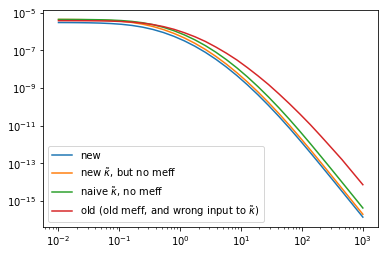

In [150]:
plt.loglog(ps_interlopers[:,0], ps_interlopers[:,1], label='new')
plt.loglog(ps_interlopers_nomeff[:,0], ps_interlopers_nomeff[:,1], label=r'new $\tilde\kappa$, but no meff')
plt.loglog(ps_interlopers_naive[:,0], ps_interlopers_naive[:,1], label=r'naive $\tilde\kappa$, no meff')
plt.loglog(ps_interlopers_old[:,0], ps_interlopers_old[:,1], label=r'old (old meff, and wrong input to $\tilde\kappa$)')
plt.legend()


### Recomputing subhalo PS
So far, we've been using the values calculated by Ana's mathematica notebook, but it would be a good sanity check to rerun the analysis here.

$$P(k) = \frac{1}{\Sigma_{cr}^2} \int_{10^5}^{10^8} m^2 \frac{d^2 N}{dmdA}(m) \left| \tilde\kappa(k r_s(m)) \right|^2 dm$$
where the surface number density is
$$\frac{d^2 N}{dmdA}(m) = (1.905\times 10^5 M_\odot^{0.9}) m^{-1.9} \,\mathrm{kpc^{-2}}$$
to use the Simon Birrer normalization (to match lenstronomy)

In [47]:
sigma_crit.to(u.M_sun/u.kpc**2).value

3116393522.745535

In [39]:
def sub_dens(m):
    factor = 1.905e5 # Msun^0.9 (following Birrer's normalization)
    return factor * m**-1.9

def sub_power(k):
    prefactor = 1/sigma_crit.to(u.M_sun/u.kpc**2).value**2
    res = quad(lambda m: m**2 * sub_dens(m) * kappa_tilde_safe(k*mass_to_rs(m))**2,
              1e5,
              1e8,
              limit=1000)
    if abs(res[1]/res[0]) > .01:
        print('high integral error:', res)
    return prefactor * res[0]

In [40]:
ksub_vals = np.logspace(-2, 3, 30) # 1/kpc
psub_vals = [sub_power(k) for k in ksub_vals]

/n/home13/atsang/.conda/envs/jup3/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # Remove the CWD from sys.path while we load stuff.


In [41]:
klist_sub = np.loadtxt('files/ksubImg_095_196_97.txt')
plist_sub = np.load('files/ind_curves_subImg_095_196_97.npy')[0]
klist_subsmall = np.loadtxt('files/ksubsmallImg_095_196_10.txt')
plist_subsmall = np.load('files/ind_curves_subsmallImg_095_196_10.npy')[0]

In [61]:
# subhalo mass between 10^5 and 10^8
ps_subhalos = np.array([[0.01, 0.000121064], [0.0125893, 0.000120882], [0.0158489, 
  0.000120614], [0.0199526, 0.000120224], [0.0251189, 
  0.000119661], [0.0316228, 0.000118854], [0.0398107, 
  0.00011771], [0.0501187, 0.00011611], [0.0630957, 
  0.000113904], [0.0794328, 0.000110919], [0.1, 
  0.000106968], [0.125893, 0.000101873], [0.158489, 
  0.0000955008], [0.199526, 0.0000878155], [0.251189, 
  0.0000789222], [0.316228, 0.0000690958], [0.398107, 
  0.0000587699], [0.501187, 0.0000484742], [0.630957, 
  0.0000387358], [0.794328, 0.0000299813], [1., 
  0.0000224772], [1.25893, 0.0000163215], [1.58489, 
  0.000011475], [1.99526, 7.80641e-6], [2.51189, 
  5.135e-6], [3.16228, 3.26397e-6], [3.98107, 
  2.00407e-6], [5.01187, 1.18868e-6], [6.30957, 
  6.81452e-7], [7.94328, 3.7796e-7], [10., 
  2.03083e-7], [12.5893, 1.05869e-7], [15.8489, 
  5.36262e-8], [19.9526, 2.6429e-8], [25.1189, 
  1.26873e-8], [31.6228, 5.93833e-9], [39.8107, 
  2.71258e-9], [50.1187, 1.21067e-9], [63.0957, 
  5.28754e-10], [79.4328, 2.2643e-10], [100., 
  9.53077e-11], [125.893, 3.95397e-11], [158.489, 
  1.62138e-11], [199.526, 6.58945e-12], [251.189, 
  2.66042e-12], [316.228, 1.06909e-12], [398.107, 
  4.28235e-13], [501.187, 1.71163e-13], [630.957, 
  6.83155e-14], [794.328, 2.72413e-14], [1000., 1.08562e-14]])

ps_subhalos_tau15 = np.array([[0.01, 0.000121185], [0.0125893, 0.000121059], [0.0158489, 
  0.000120874], [0.0199526, 0.000120602], [0.0251189, 
  0.000120206], [0.0316228, 0.000119633], [0.0398107, 
  0.000118812], [0.0501187, 0.000117646], [0.0630957, 
  0.000116014], [0.0794328, 0.000113762], [0.1, 
  0.000110709], [0.125893, 0.00010666], [0.158489, 
  0.000101429], [0.199526, 0.0000948767], [0.251189, 
  0.0000869609], [0.316228, 0.0000777909], [0.398107, 
  0.0000676595], [0.501187, 0.0000570328], [0.630957, 
  0.0000464842], [0.794328, 0.0000365854], [1., 
  0.0000277947], [1.25893, 0.0000203853], [1.58489, 
  0.0000144367], [1.99526, 9.87261e-6], [2.51189, 
  6.51843e-6], [3.16228, 4.15445e-6], [3.98107, 
  2.55575e-6], [5.01187, 1.518e-6], [6.30957, 
  8.71092e-7], [7.94328, 4.83466e-7], [10., 
  2.59889e-7], [12.5893, 1.35523e-7], [15.8489, 
  6.866e-8], [19.9526, 3.38423e-8], [25.1189, 
  1.62472e-8], [31.6228, 7.60478e-9], [39.8107, 
  3.47383e-9], [50.1187, 1.55042e-9], [63.0957, 
  6.77127e-10], [79.4328, 2.89962e-10], [100., 
  1.22047e-10], [125.893, 5.0632e-11], [158.489, 
  2.0762e-11], [199.526, 8.43781e-12], [251.189, 
  3.40664e-12], [316.228, 1.36896e-12], [398.107, 
  5.48347e-13], [501.187, 2.19171e-13], [630.957, 
  8.74764e-14], [794.328, 3.48818e-14], [1000., 1.39011e-14]]) # from Ana's code; also units in kpc

In [62]:
sub_power(1e-10)

1.1245531629163928e-05

In [63]:
ps_subhalos[0,1] * 1.902e5/1.906e6 * (3/3.11)**2 # Ana's Mathematica code used 3e9 istd of 3.11e9 for sigmacr

1.1241502638570132e-05

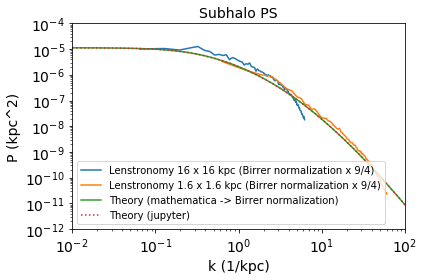

In [71]:
plt.loglog(klist_sub, plist_sub*9/4, label='Lenstronomy 16 x 16 kpc (Birrer normalization x 9/4)')
plt.loglog(klist_subsmall, plist_subsmall*9/4, label='Lenstronomy 1.6 x 1.6 kpc (Birrer normalization x 9/4)')
plt.loglog(ps_subhalos[:,0], ps_subhalos[:,1] * 1.902e5/1.906e6 * (3/3.11)**2, label='Theory (mathematica -> Birrer normalization)')
plt.loglog(ksub_vals, psub_vals, ':', label='Theory (jupyter)')
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1e-2,1e2)
plt.ylim(1e-12,1e-4)
plt.xlabel('k (1/kpc)', fontsize=14)
plt.ylabel('P (kpc^2)', fontsize=14)
plt.title('Subhalo PS', fontsize=14)
plt.tight_layout()
#plt.savefig('imgs/mar18_subpower.png')

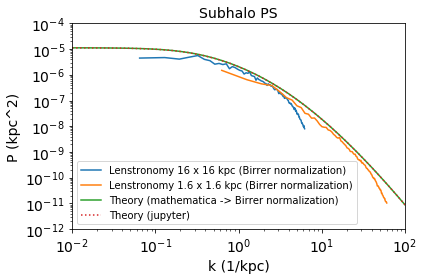

In [72]:
plt.loglog(klist_sub, plist_sub, label='Lenstronomy 16 x 16 kpc (Birrer normalization)')
plt.loglog(klist_subsmall, plist_subsmall, label='Lenstronomy 1.6 x 1.6 kpc (Birrer normalization)')
plt.loglog(ps_subhalos[:,0], ps_subhalos[:,1] * 1.902e5/1.906e6 * (3/3.11)**2, label='Theory (mathematica -> Birrer normalization)')
plt.loglog(ksub_vals, psub_vals, ':', label='Theory (jupyter)')
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1e-2,1e2)
plt.ylim(1e-12,1e-4)
plt.xlabel('k (1/kpc)', fontsize=14)
plt.ylabel('P (kpc^2)', fontsize=14)
plt.title('Subhalo PS', fontsize=14)
plt.tight_layout()
#plt.savefig('imgs/mar18_subpower.png')

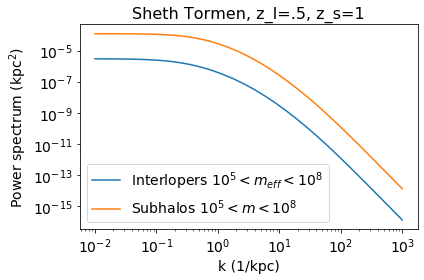

In [53]:
plt.plot(ps_interlopers[:,0], ps_interlopers[:,1], #ps_interlopers_err,
             label='Interlopers $10^5 < m_{eff} < 10^8$')
plt.plot(ps_subhalos[:,0], ps_subhalos[:,1], label='Subhalos $10^5 < m < 10^8$')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel('k (1/kpc)', size=14)
plt.ylabel('Power spectrum ($\\mathrm{kpc}^2$)', size=14)

plt.gca().tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.title('Sheth Tormen, z_l=.5, z_s=1', size=16)
plt.tight_layout()
#plt.savefig('imgs/feb28_ps_st.png')
plt.show()

# Old cells

In [ ]:
# If we didn't record what the mass vals were, we can approximate them like this
mass_vals = 1e6 * u.M_sun * (kappa_tildes_rs_rt[:,0] / (0.1 * u.kpc))**3
#print(mass_vals)

In [ ]:
plt.loglog(mass_vals, kappa_tildes_rs_rt[:,0], 'o-')

In [ ]:
# has to be unitless because it goes in the integral
kappa_tilde_func = interp2d(kappa_tildes_k.to(1/u.kpc).value,
                            mass_vals.to(u.M_sun).value,
                            kappa_tildes_matrix.T,
                            bounds_error=True)

In [ ]:
k_vals = kappa_tildes_k.to(1/u.kpc).value
plt.imshow(kappa_tildes_matrix, extent=(np.log10(min(mass_vals.value)),
                                        np.log10(max(mass_vals.value)),
                                       
                                        np.log10(max(k_vals)),
                                        np.log10(min(k_vals)),),
           aspect='auto')
plt.colorbar()
plt.ylabel('log10 k')
plt.xlabel('log10 mass')